<font color="#de3023"><h1><b>MAKE A COPY OF THIS NOTEBOOK SO YOUR EDITS ARE SAVED</b></h1></font>


We work for CC: ConscientiousCars, where we help self-driving vehicles be more conscientious of their surroundings. Our cars have been very good at recognizing and avoiding humans. They haven't, however, been capable of recognizing dogs. Since dogs are man's best friend and will always be where we humans are, we want our cars to know if a dog is on the road in front of them and avoid the dog!

The first step to avoiding these cute puppies is **knowing if a puppy is in front of the car**. So today we will **build a detector that can tell when our car sees a dog or not**!

In this notebook, you'll:
- Explore the cars vs. roads dataset
- Train a simple K-neighbors classifier for computer vision
- Train neural nets to tell dogs from roads
- Improve your model with convolutional neural networks!



In [2]:
#@title Run this to load some packages and data! { display-mode: "form" }
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  import gdown
  # gdown.download('https://drive.google.com/uc?id=1-BjeqccJdLiBA6PnNinmXSQ6w5BluLem','cifar_data','True'); # dogs v road;
  !wget -O cifar_data https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));
  
  data   = data_dict['data']
  labels = data_dict['labels']
  
  return data, labels

def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  my_img   = data[img_idx, :].squeeze().reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print('label: %s'%my_label)
  fig, ax = plt.subplots(1,1)

  img = ax.imshow(my_img, extent=[-1,1,-1,1])

  x_label_list = [0, 8, 16, 24, 32]
  y_label_list = [0, 8, 16, 24, 32]

  ax.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax.set_yticks([-1, -0.5, 0, 0.5, 1])

  ax.set_xticklabels(x_label_list)
  ax.set_yticklabels(y_label_list)

  fig.show(img)

def categorical_to_numpy(labels_in):
  return np.array(list(map(lambda x: np.array([1, 0]) if x == "dog" else np.array([0, 1]), labels_in)), dtype="float32")
  
def CNNClassifier(num_epochs=30):
  def create_model():
    model = Sequential()
    model.add(Reshape((32, 32, 3)))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
  return KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=10, verbose=2)


def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 7)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

# Understanding our data

Our cars are very attentive and always have their eyes on the road.

Every second, they're streaming in data about the street, including video.

From this video data, we want our car to tell: is there 'road' or 'dog' in front of it?

Lucky for us, we have a dataset of dog and road images already prepared! Let's start by reading that *labeled* data in. 


In [3]:
# load our data 
data, labels = load_data()

--2022-07-11 17:16:51--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3689015 (3.5M) [application/octet-stream]
Saving to: ‘cifar_data’

cifar_data          100%[===================>]   3.52M  --.-KB/s    in 0.02s   

2022-07-11 17:16:51 (169 MB/s) - ‘cifar_data’ saved [3689015/3689015]



Let's look at an image of a dog!

Try changing the number below. What does it do?



label: dog


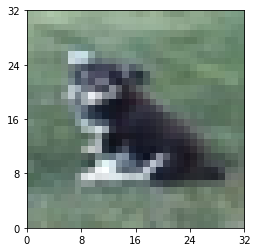

In [4]:
plot_one_image(data, labels, 4) #change this number

**Discuss:** Why might we be using such blurry images?

Next, let's try a road image. Again, try changing the number:

label: road


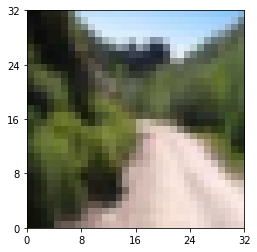

In [5]:
plot_one_image(data, labels, 700) #change this number

How many images do we have?

In [6]:
print(len(data))
print(Counter(labels))

1200
Counter({'dog': 600, 'road': 600})


The dataset is organized such 600 images are pictures of dogs and the last 600 images are pictures of roads.

#### Optional Exercise: Examining More Images

**Look at a few more images of both classes.** 

Try using a `for` loop to look at 5 images!

label: dog
label: dog
label: dog
label: dog
label: dog


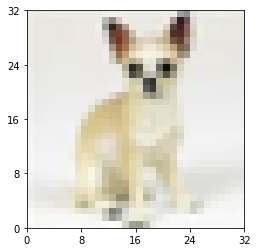

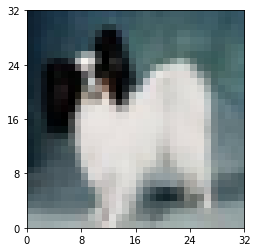

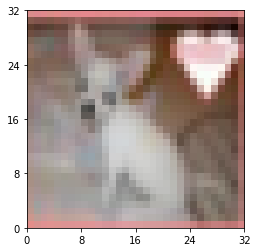

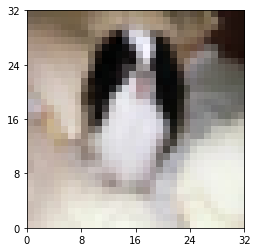

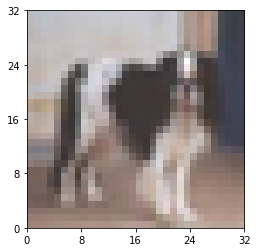

In [7]:
### YOUR CODE HERE
for i in range (420, 425, 1):
  plot_one_image(data, labels, i)

#for i in (random numbers)
  #plot_one_image(data, labels, i)

### END CODE

##Understanding our Data Representation

In an image each pixel is denoted by 3 numbers that represent the intensity value of that pixel (0 - 255) for each color channel (R, G, and B). Below we 
see a list of numbers for each image that represent the intensity values. 


In [8]:
print('One image looks like: ')
print(data[0])
print("Length of list: ", len(data[0]))

One image looks like: 
[45 20 19 ... 83 99 31]
Length of list:  3072


**Discuss:** What does each number mean? Can you explain the length of the list?


In [9]:
#@title Exercise: Fill in the correct values for each image's height, width, and number of color channels:

img_height = 32#@param {type:"integer"}
img_width =  32#@param {type:"integer"}
color_channels =  3#@param {type:"integer"}

if img_height == 32 and img_width == 32 and color_channels == 3:
  print("Correct!")
  print ("Each image is", img_height, 'x', img_width, 'pixels.')
  print ("Each pixel has", color_channels, "channels for red, green, blue.")
  print ("This gives a total of", img_height * img_width * color_channels, "intensity values per image.")
else:
  print("Those aren't quite the values.")
  print("Your values give a total of", img_height * img_width * color_channels, "intensity values per image.") 
  print("Discuss with your group and try again!")



Correct!
Each image is 32 x 32 pixels.
Each pixel has 3 channels for red, green, blue.
This gives a total of 3072 intensity values per image.


We use these values as **inputs** to predict an **output** label: 'dog' or 'road'!

Here's what our entire dataset looks like:

In [10]:
print ('Data shape:', data.shape)
print ('Data:', data)

Data shape: (1200, 3072)
Data: [[ 45  20  19 ...  83  99  31]
 [101 114  35 ... 155 134  91]
 [213 221 221 ... 139  58  47]
 ...
 [126 174 202 ... 124 128 129]
 [191 232 240 ...  74  93  81]
 [237 248 254 ...  45  56  10]]



# A simple machine learner




We want to create a machine learning *model* that can tell us whether a new image is either a `dog` or a `road`. 

We will give our *model* a *training manual* of data and labels that it will study or train on. 

We then check how well our model is doing on a *test*, where it is given data and told to predict their labels. 



## Splitting our data


Let's first build our training manual and test from our data set. Below, we select randomly 20% of the data for the test, and 80% for the train. 

**Discuss:** Why do we need both testing and training data?



In [11]:
# Preparing data and create training and test inputs and labels
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=1)

## Creating our model

Now we will build and train a simple model. We will use the `KNeighborsClassifier` and train our model with `fit`, giving it the training inputs and labels. 

**Playground**: Explore [this demo](http://vision.stanford.edu/teaching/cs231n-demos/knn/) to understand what the KNN model is doing! 

**Exercise:** Please train the model below.

In [12]:
# Defining our classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Training our model (1 line)
knn.fit(X_train, y_train)
#YOUR CODE HERE

KNeighborsClassifier()

## Testing how our model did

Finally, we check  how our model did by giving it a *test*. The accuracy score tells us what percentage of test data it classified correctly. 100% means that all the images were classified correctly.

**Exercise:** Please fill in the predictions on the test set.

In [13]:
# Predict what the classes are based on the testing data
y_pred = knn.predict(X_test)
print(y_pred)
#YOUR CODE HERE

['road' 'road' 'road' 'dog' 'dog' 'dog' 'road' 'road' 'dog' 'road' 'dog'
 'dog' 'dog' 'dog' 'road' 'road' 'road' 'dog' 'dog' 'road' 'road' 'dog'
 'road' 'road' 'road' 'road' 'road' 'dog' 'road' 'dog' 'road' 'road' 'dog'
 'road' 'dog' 'road' 'road' 'dog' 'road' 'dog' 'dog' 'road' 'dog' 'dog'
 'road' 'road' 'road' 'road' 'road' 'dog' 'road' 'road' 'road' 'dog' 'dog'
 'road' 'road' 'road' 'road' 'dog' 'road' 'road' 'dog' 'road' 'road'
 'road' 'road' 'road' 'road' 'road' 'dog' 'road' 'road' 'road' 'road'
 'dog' 'dog' 'dog' 'road' 'road' 'dog' 'road' 'dog' 'dog' 'road' 'dog'
 'road' 'road' 'road' 'road' 'road' 'road' 'road' 'road' 'dog' 'road'
 'dog' 'road' 'road' 'road' 'road' 'road' 'road' 'road' 'dog' 'road' 'dog'
 'road' 'road' 'dog' 'road' 'road' 'road' 'road' 'road' 'dog' 'dog' 'dog'
 'road' 'dog' 'dog' 'dog' 'road' 'road' 'road' 'road' 'dog' 'dog' 'dog'
 'road' 'road' 'road' 'dog' 'road' 'road' 'road' 'dog' 'road' 'dog' 'dog'
 'road' 'road' 'dog' 'dog' 'road' 'road' 'road' 'road' 'ro

Now, let's calculate the accuracy!

In [14]:
print("KNN Testing Set Accuracy:")
# Print the score on the testing data
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
#YOUR CODE HERE

KNN Testing Set Accuracy:
0.7916666666666666


## Predicting on images

We can use our trained model to predict whether our car is seeing a `dog` or `road`. Let's try this out - experiment with different images!


label: dog
prediction: road


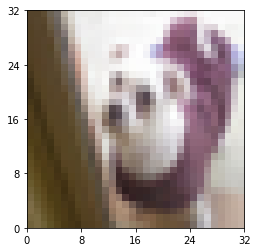

In [15]:
# Specify which image you want to show
image_id = 239 #Change this!

# Visualize the image
plot_one_image(X_test, y_test, image_id)

# Use the model to predict what this might be and print it
print('prediction:', knn.predict([X_test[image_id]])[0])

## Your turn! 


###Exercise: Building a KNN ✍️


Build your own KNN model where you change the number of neighbors. Try to see how high you can make the accuracy go!! We want our pets to be safe, after all. 

In [16]:
### YOUR CODE HERE
# Defining our classifier
knn = KNeighborsClassifier(n_neighbors=10) # Change this!

# Training our model with its training input data and labels
knn.fit(X_train, y_train)

# Predict what the classes are based on the testing data
y_pred = knn.predict(X_test)

# Calculate the accuracy score on the testing data
accuracy = accuracy_score(y_test, y_pred)

# Print the score on the testing data
print(accuracy)

### END CODE

0.8291666666666667


### (Optional) exercise: Experimenting with the number of neighbors

Use a **for loop** to try out several different values of **k**, and see how high your accuracy can get. 

In [18]:
### YOUR CODE HERE
#k_values = list(range(1,100))
#scores = []

#for k in k_values:
  #knn = KNeighborsClassifier(n_neighbors=i)
 # Training our model with its training input data and labels
  #knn.fit(X_train, y_train)

# Predict what the classes are based on the testing data
  #y_pred = knn.predict(X_test)

# Calculate the accuracy score on the testing data
  #accuracy = accuracy_score(y_test, y_pred)

#plt.plot(k_values, accuracy)
#plt.xlabel("k_values")
#plt.ylabel("accuracy")
#plt.show()

### END CODE

**Discuss:** What are the advantages and disadvantages of using a bigger vs. smaller **k**?

#Neural Networks
Now, let's create some new models using neural networks!

You can play around with [TensorFlow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.62283&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&learningRate_hide=true&batchSize_hide=true&stepButton_hide=true&activation_hide=true) to get a feel for how neural nets work.

To build a simple neural network, we use `MLPClassifier` from scikit-learn. We will play with the **number of neurons** and the **number of hidden layers** to adjust the complexity of our model, just like we did in Playground!

**Example 1:**
Here's how we create a neural network with 1 hidden layer of 3 neurons.

`nnet = MLPClassifier(hidden_layer_sizes=(3)) `

**Example 2:**

Here's how we create a neural network with 2 hidden layers: one of 3 neurons and one of 4 neurons.

`nnet = MLPClassifier(hidden_layer_sizes=(3, 4)) `

**Discuss:** How might you build a neural network with 3 hidden layers? Run and modify the example below!

In [19]:
# Create and train our multi layer perceptron model
nnet = MLPClassifier(hidden_layer_sizes=(10, 5, 4), random_state=1, max_iter= 10000)  ## How many hidden layers? How many neurons does this have?
nnet.fit(X_train, y_train)

# Predict what the classes are based on the testing data
predictions = nnet.predict(X_test)

# Print the score on the testing data
print("MLP Testing Accuracy:")
print(accuracy_score(y_test, predictions)*100)

MLP Testing Accuracy:
86.66666666666667


**How well did your neural network perform?** 

Multilayer perceptrons are more complex models and it can be difficult to find the right "settings" for them. It takes some trial and error!

**Exercise: try the following out and see how well you can get your network to do!**
* Train a 1 layer, 10 neuron network for practice
* Change the number of neurons and/or add layers to see how well you can do
* Increase or decrease the number of iterations

In [20]:
### YOUR CODE HERE
nnet = MLPClassifier(hidden_layer_sizes=(100), random_state=1, max_iter= 1000000)  ## How many hidden layers? How many neurons does this have?
nnet.fit(X_train, y_train)

# Predict what the classes are based on the testing data
predictions = nnet.predict(X_test)

# Print the score on the testing data
print("MLP Testing Accuracy:")
print(accuracy_score(y_test, predictions)*100)


MLP Testing Accuracy:
88.33333333333333


###Automating our Experiments 
Here we use a for loop to explore various combinations of number of layers and number of hidden neurons within each layer. Neural networks are hard to tune, so it can be hard to choose the right settings! The model performance can vary a lot. 

**Exercise:** Try at least 10 configurations to choose the best parameters.

In [21]:
for layers in [(1), (1,1), (10), (10,5), (64, 32, 16, 8, 4)]: #ADD MORE HERE!

  print('Layer parameters are ...')
  print(layers)
  nnet = MLPClassifier(hidden_layer_sizes=layers, random_state=1, max_iter=1000) 

  nnet.fit(X_train, y_train)

  # Predict what the classes are based on the testing data
  predictions = nnet.predict(X_test)

  # Print the score on the testing data
  print("MLP Testing Accuracy:")
  print(accuracy_score(y_test, predictions)*100)  

Layer parameters are ...
1
MLP Testing Accuracy:
52.916666666666664
Layer parameters are ...
(1, 1)
MLP Testing Accuracy:
47.083333333333336
Layer parameters are ...
10
MLP Testing Accuracy:
52.916666666666664
Layer parameters are ...
(10, 5)
MLP Testing Accuracy:
47.083333333333336
Layer parameters are ...
(64, 32, 16, 8, 4)
MLP Testing Accuracy:
90.83333333333333


# Models for Vision: Convolutional Neural Networks

There is a famous type of neural network known as a convolutional neural network (CNN). These types of neural networks work very well on computer vision problems. 

If you're interested in learning more about CNNs, spend some time exploring the [CNN Explainer](https://poloclub.github.io/cnn-explainer/)!


Let's try one out!

In [ ]:
# convert our data to floats for our CNN
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Create and train our CNN model
cnn = CNNClassifier(num_epochs = 50)
cnn.fit(X_train, y_train)

# Predict what the classes are based on the testing data
predictions = cnn.predict(X_test)

# Print the score on the testing data
print("CNN Testing Accuracy:")
print(accuracy_score(y_test, predictions)*100)

**Discuss: Is this CNN good enough to use in practice?** 

CNNs typically perform better than basic Neural Networks on vision problems - but like basic Neural Networks, they aren't always consistent in their results and are sensitive to a number of factors.

**Report to the class your highest model accuracy.**

**Bonus Question:** Each of you might see a different max accuracy. Can you think of why that might be?


## Bonus (Optional): Training and Validation Curves

An important aspect of training neural networks is to prevent overfitting. **How do you know when your model is overfitting?**

To plot our model's history, we can train it with
```
history = model.fit(X_train, categorical_to_numpy(y_train), validation_data=(X_test, categorical_to_numpy(y_test)))
```

and then use
```
plot_acc(history)
```
Don't forget to change ```model``` to be the name of your model!

**Exercise:** Train a CNN model and plot a train vs. test curve.

**After how many epochs does the model begin to overfit?** Overfitting occurs when the validation accuracy starts to drop below the training accuracy.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/100
96/96 - 10s - loss: 7.4530 - accuracy: 0.6396 - val_loss: 0.5150 - val_accuracy: 0.8208 - 10s/epoch - 99ms/step
Epoch 2/100
96/96 - 6s - loss: 1.7505 - accuracy: 0.7719 - val_loss: 0.3250 - val_accuracy: 0.8542 - 6s/epoch - 61ms/step
Epoch 3/100
96/96 - 6s - loss: 0.6712 - accuracy: 0.8458 - val_loss: 0.2824 - val_accuracy: 0.8875 - 6s/epoch - 61ms/step
Epoch 4/100
96/96 - 6s - loss: 0.4305 - accuracy: 0.8833 - val_loss: 0.3653 - val_accuracy: 0.8500 - 6s/epoch - 61ms/step
Epoch 5/100
96/96 - 6s - loss: 0.3424 - accuracy: 0.8896 - val_loss: 0.2179 - val_accuracy: 0.9125 - 6s/epoch - 62ms/step
Epoch 6/100
96/96 - 6s - loss: 0.3093 - accuracy: 0.9042 - val_loss: 0.1500 - val_accuracy: 0.9583 - 6s/epoch - 63ms/step
Epoch 7/100
96/96 - 6s - loss: 0.2086 - accuracy: 0.9271 - val_loss: 0.1750 - val_accuracy: 0.9208 - 6s/epoch - 61ms/step
Epoch 8/100
96/96 - 6s - loss: 0.2259 - accuracy: 0.9219 - val_loss: 0.2164 - val_accuracy: 0.9250 - 6s/epoch - 62ms/step
Epoch 9/100
96/96 - 6s

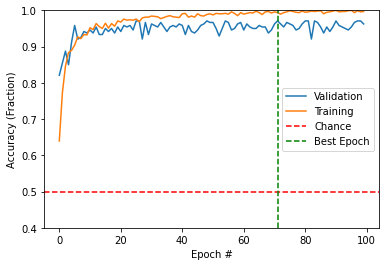

In [29]:
### YOUR CODE HERE
cnn = CNNClassifier(num_epochs = 100)
history = cnn.fit(X_train, categorical_to_numpy(y_train), validation_data=(X_test, categorical_to_numpy(y_test)))

plot_acc(history)

### END CODE

### Hopefully your CNN worked *very* well! We want to keep the doggos as safe as they can be.

![](https://images.pexels.com/photos/316/black-and-white-animal-dog-pet.jpg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)